# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

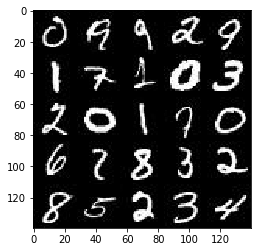

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

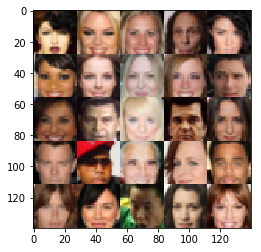

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # From Intro to GANS Exercise
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # From Deep Convolutional GANS Exercise
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse): 
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
            
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # From Deep Convolutional GANS Exercise
    alpha = 0.2
    reuse = not is_train 
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 8x8x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # From Deep Convolutional GANS Exercise
    alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Hints from Florian Wilhelm GitHub & DCGAN Notebook
   # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 32
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.6668... Generator Loss: 1.1232
Epoch 0/2... Discriminator Loss: 0.4996... Generator Loss: 1.5088
Epoch 0/2... Discriminator Loss: 0.4237... Generator Loss: 1.6654
Epoch 0/2... Discriminator Loss: 0.6726... Generator Loss: 0.9587


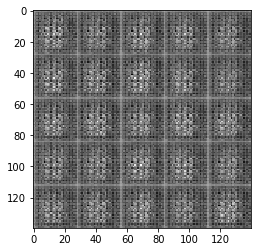

Epoch 0/2... Discriminator Loss: 0.6320... Generator Loss: 0.9670
Epoch 0/2... Discriminator Loss: 0.1972... Generator Loss: 4.3993
Epoch 0/2... Discriminator Loss: 0.3145... Generator Loss: 2.1475
Epoch 0/2... Discriminator Loss: 0.2249... Generator Loss: 4.0555
Epoch 0/2... Discriminator Loss: 0.3938... Generator Loss: 1.4952


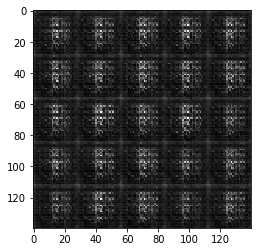

Epoch 0/2... Discriminator Loss: 0.2326... Generator Loss: 2.4984
Epoch 0/2... Discriminator Loss: 0.4260... Generator Loss: 3.3952
Epoch 0/2... Discriminator Loss: 0.1993... Generator Loss: 4.6491
Epoch 0/2... Discriminator Loss: 0.1264... Generator Loss: 3.0790
Epoch 0/2... Discriminator Loss: 0.2392... Generator Loss: 2.5524


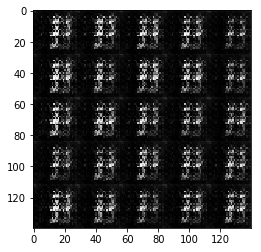

Epoch 0/2... Discriminator Loss: 0.1331... Generator Loss: 3.0182
Epoch 0/2... Discriminator Loss: 0.1329... Generator Loss: 3.2398
Epoch 0/2... Discriminator Loss: 0.0754... Generator Loss: 3.5121
Epoch 0/2... Discriminator Loss: 0.0928... Generator Loss: 3.2787
Epoch 0/2... Discriminator Loss: 0.2802... Generator Loss: 3.1808


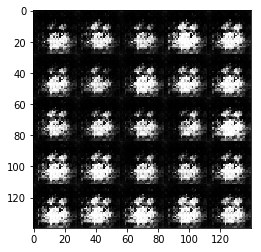

Epoch 0/2... Discriminator Loss: 0.1118... Generator Loss: 7.5618
Epoch 0/2... Discriminator Loss: 0.1211... Generator Loss: 3.5152
Epoch 0/2... Discriminator Loss: 0.1605... Generator Loss: 2.8612
Epoch 0/2... Discriminator Loss: 0.2384... Generator Loss: 2.2575
Epoch 0/2... Discriminator Loss: 0.0401... Generator Loss: 4.6538


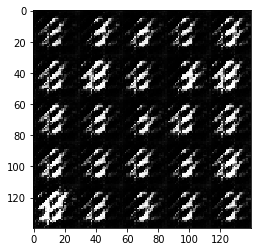

Epoch 0/2... Discriminator Loss: 0.1635... Generator Loss: 2.9591
Epoch 0/2... Discriminator Loss: 0.1183... Generator Loss: 3.0823
Epoch 0/2... Discriminator Loss: 0.1091... Generator Loss: 3.4315
Epoch 0/2... Discriminator Loss: 0.2105... Generator Loss: 2.6444
Epoch 0/2... Discriminator Loss: 0.1093... Generator Loss: 3.8564


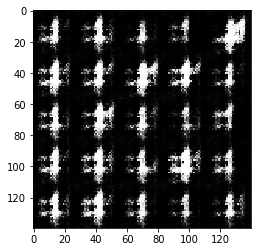

Epoch 0/2... Discriminator Loss: 0.1793... Generator Loss: 2.5444
Epoch 0/2... Discriminator Loss: 0.1343... Generator Loss: 4.0042
Epoch 0/2... Discriminator Loss: 0.1276... Generator Loss: 3.3665
Epoch 0/2... Discriminator Loss: 0.1832... Generator Loss: 2.8373
Epoch 0/2... Discriminator Loss: 0.2592... Generator Loss: 2.5002


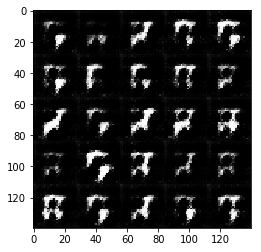

Epoch 0/2... Discriminator Loss: 0.2395... Generator Loss: 5.2731
Epoch 0/2... Discriminator Loss: 0.1490... Generator Loss: 4.0719
Epoch 0/2... Discriminator Loss: 0.2633... Generator Loss: 2.1654
Epoch 0/2... Discriminator Loss: 0.1884... Generator Loss: 2.6214
Epoch 0/2... Discriminator Loss: 0.2732... Generator Loss: 2.1761


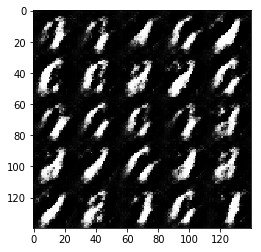

Epoch 0/2... Discriminator Loss: 0.1724... Generator Loss: 2.9991
Epoch 0/2... Discriminator Loss: 0.1490... Generator Loss: 2.9450
Epoch 0/2... Discriminator Loss: 0.1417... Generator Loss: 3.2171
Epoch 0/2... Discriminator Loss: 0.1290... Generator Loss: 2.9159
Epoch 0/2... Discriminator Loss: 0.1922... Generator Loss: 2.4160


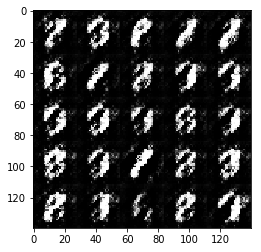

Epoch 0/2... Discriminator Loss: 0.1915... Generator Loss: 3.3568
Epoch 0/2... Discriminator Loss: 0.1425... Generator Loss: 3.0005
Epoch 0/2... Discriminator Loss: 0.1418... Generator Loss: 3.2652
Epoch 0/2... Discriminator Loss: 0.1585... Generator Loss: 2.9103
Epoch 0/2... Discriminator Loss: 0.1345... Generator Loss: 2.8246


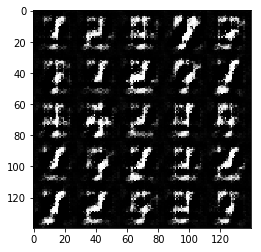

Epoch 0/2... Discriminator Loss: 0.0704... Generator Loss: 3.9913
Epoch 0/2... Discriminator Loss: 0.2166... Generator Loss: 2.5520
Epoch 0/2... Discriminator Loss: 0.1354... Generator Loss: 3.6560
Epoch 0/2... Discriminator Loss: 0.2918... Generator Loss: 4.2476
Epoch 0/2... Discriminator Loss: 0.2937... Generator Loss: 1.6846


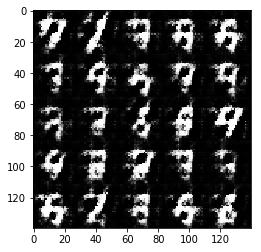

Epoch 0/2... Discriminator Loss: 0.5849... Generator Loss: 1.0378
Epoch 0/2... Discriminator Loss: 0.2958... Generator Loss: 2.3852
Epoch 0/2... Discriminator Loss: 0.1900... Generator Loss: 2.9572
Epoch 0/2... Discriminator Loss: 0.2510... Generator Loss: 2.2644
Epoch 0/2... Discriminator Loss: 0.2149... Generator Loss: 2.2011


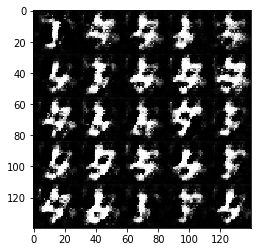

Epoch 0/2... Discriminator Loss: 0.1676... Generator Loss: 2.9034
Epoch 0/2... Discriminator Loss: 0.2604... Generator Loss: 4.4303
Epoch 0/2... Discriminator Loss: 0.2439... Generator Loss: 2.2476
Epoch 0/2... Discriminator Loss: 0.1445... Generator Loss: 2.6526
Epoch 0/2... Discriminator Loss: 0.2678... Generator Loss: 2.6041


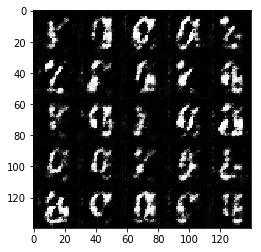

Epoch 0/2... Discriminator Loss: 0.2924... Generator Loss: 2.5185
Epoch 0/2... Discriminator Loss: 0.3637... Generator Loss: 1.8526
Epoch 0/2... Discriminator Loss: 0.3748... Generator Loss: 2.7162
Epoch 0/2... Discriminator Loss: 0.4521... Generator Loss: 3.5023
Epoch 0/2... Discriminator Loss: 0.6022... Generator Loss: 4.0777


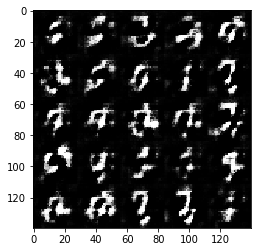

Epoch 0/2... Discriminator Loss: 0.3334... Generator Loss: 1.8694
Epoch 0/2... Discriminator Loss: 0.4062... Generator Loss: 3.7977
Epoch 0/2... Discriminator Loss: 0.3503... Generator Loss: 2.1382
Epoch 0/2... Discriminator Loss: 0.2868... Generator Loss: 2.4354
Epoch 0/2... Discriminator Loss: 0.4240... Generator Loss: 3.0279


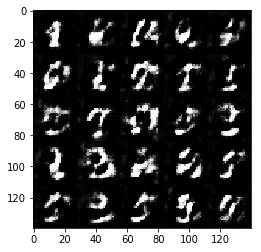

Epoch 0/2... Discriminator Loss: 0.4107... Generator Loss: 2.1533
Epoch 0/2... Discriminator Loss: 0.3230... Generator Loss: 2.6639
Epoch 0/2... Discriminator Loss: 0.2642... Generator Loss: 3.4365
Epoch 0/2... Discriminator Loss: 0.2595... Generator Loss: 2.8747
Epoch 0/2... Discriminator Loss: 0.3347... Generator Loss: 2.3237


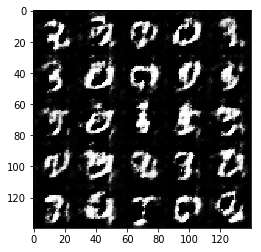

Epoch 0/2... Discriminator Loss: 0.6809... Generator Loss: 4.6936
Epoch 0/2... Discriminator Loss: 0.4833... Generator Loss: 2.6948
Epoch 0/2... Discriminator Loss: 0.3479... Generator Loss: 2.2078
Epoch 0/2... Discriminator Loss: 0.4084... Generator Loss: 2.8001
Epoch 0/2... Discriminator Loss: 0.3610... Generator Loss: 1.9392


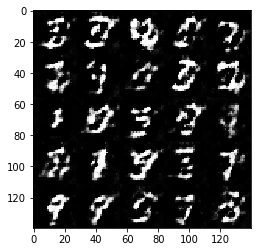

Epoch 0/2... Discriminator Loss: 0.5936... Generator Loss: 3.8035
Epoch 0/2... Discriminator Loss: 0.2956... Generator Loss: 3.4060
Epoch 0/2... Discriminator Loss: 0.8492... Generator Loss: 4.0718
Epoch 0/2... Discriminator Loss: 0.7326... Generator Loss: 1.1181
Epoch 0/2... Discriminator Loss: 0.9612... Generator Loss: 4.8991


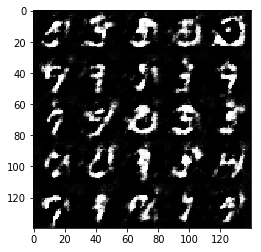

Epoch 0/2... Discriminator Loss: 0.4270... Generator Loss: 1.9224
Epoch 0/2... Discriminator Loss: 0.3588... Generator Loss: 2.4082
Epoch 0/2... Discriminator Loss: 0.3505... Generator Loss: 3.0726
Epoch 0/2... Discriminator Loss: 1.0413... Generator Loss: 4.6064
Epoch 1/2... Discriminator Loss: 0.2977... Generator Loss: 2.7191


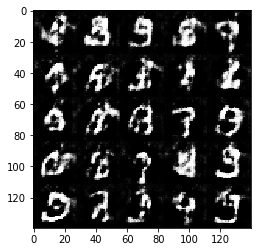

Epoch 1/2... Discriminator Loss: 0.6818... Generator Loss: 3.5952
Epoch 1/2... Discriminator Loss: 0.7388... Generator Loss: 3.5307
Epoch 1/2... Discriminator Loss: 0.4502... Generator Loss: 1.7150
Epoch 1/2... Discriminator Loss: 0.4288... Generator Loss: 1.7939
Epoch 1/2... Discriminator Loss: 0.4291... Generator Loss: 2.8766


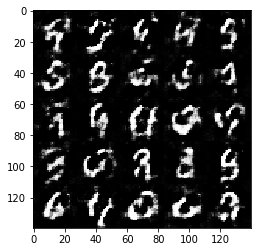

Epoch 1/2... Discriminator Loss: 0.5344... Generator Loss: 1.5200
Epoch 1/2... Discriminator Loss: 0.4692... Generator Loss: 1.8305
Epoch 1/2... Discriminator Loss: 0.3411... Generator Loss: 2.3178
Epoch 1/2... Discriminator Loss: 0.4837... Generator Loss: 1.6266
Epoch 1/2... Discriminator Loss: 0.4201... Generator Loss: 1.7438


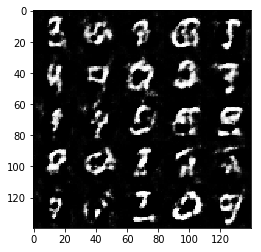

Epoch 1/2... Discriminator Loss: 0.4290... Generator Loss: 1.6635
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 3.2702
Epoch 1/2... Discriminator Loss: 0.6277... Generator Loss: 1.1606
Epoch 1/2... Discriminator Loss: 0.3731... Generator Loss: 2.6091
Epoch 1/2... Discriminator Loss: 0.4003... Generator Loss: 2.9697


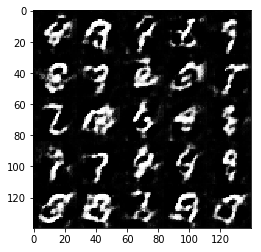

Epoch 1/2... Discriminator Loss: 0.5549... Generator Loss: 1.5759
Epoch 1/2... Discriminator Loss: 0.8021... Generator Loss: 4.0472
Epoch 1/2... Discriminator Loss: 0.5164... Generator Loss: 1.8066
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 0.9056... Generator Loss: 0.7343


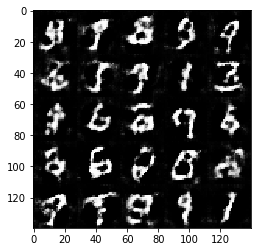

Epoch 1/2... Discriminator Loss: 0.3785... Generator Loss: 2.3991
Epoch 1/2... Discriminator Loss: 0.4614... Generator Loss: 2.0884
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 3.9302
Epoch 1/2... Discriminator Loss: 0.3789... Generator Loss: 2.0922
Epoch 1/2... Discriminator Loss: 0.4796... Generator Loss: 2.0806


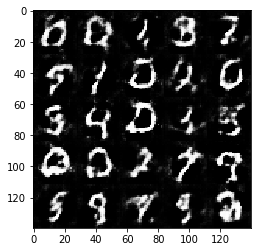

Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 1.6225
Epoch 1/2... Discriminator Loss: 0.5605... Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 0.5892... Generator Loss: 1.6317
Epoch 1/2... Discriminator Loss: 0.6413... Generator Loss: 0.9879
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.5814


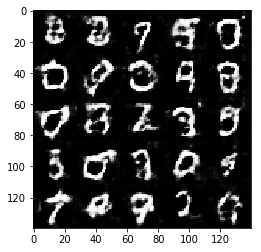

Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.4994
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 1.4885
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 2.3341
Epoch 1/2... Discriminator Loss: 0.6126... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 0.5740... Generator Loss: 1.4615


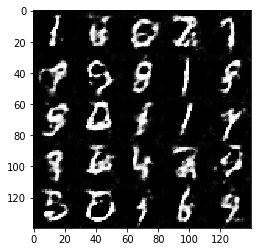

Epoch 1/2... Discriminator Loss: 1.5972... Generator Loss: 0.3377
Epoch 1/2... Discriminator Loss: 0.6693... Generator Loss: 1.0427
Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 1.1880
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 1.4509
Epoch 1/2... Discriminator Loss: 0.5569... Generator Loss: 2.1102


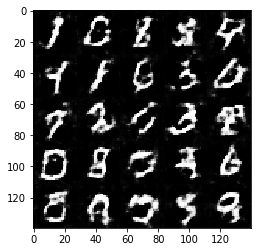

Epoch 1/2... Discriminator Loss: 0.8119... Generator Loss: 0.8310
Epoch 1/2... Discriminator Loss: 0.5057... Generator Loss: 1.5236
Epoch 1/2... Discriminator Loss: 0.6506... Generator Loss: 1.7684
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 0.6294... Generator Loss: 1.2834


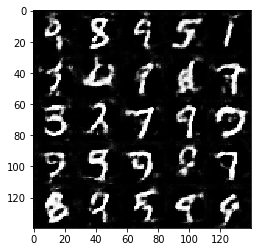

Epoch 1/2... Discriminator Loss: 0.6240... Generator Loss: 2.7460
Epoch 1/2... Discriminator Loss: 0.6002... Generator Loss: 2.2389
Epoch 1/2... Discriminator Loss: 0.5907... Generator Loss: 1.6052
Epoch 1/2... Discriminator Loss: 0.6372... Generator Loss: 2.1586
Epoch 1/2... Discriminator Loss: 0.5166... Generator Loss: 1.5153


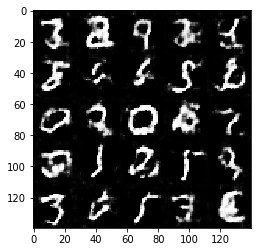

Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 0.5668... Generator Loss: 1.6280
Epoch 1/2... Discriminator Loss: 0.9527... Generator Loss: 0.7391
Epoch 1/2... Discriminator Loss: 0.5631... Generator Loss: 1.4604
Epoch 1/2... Discriminator Loss: 0.4572... Generator Loss: 1.7188


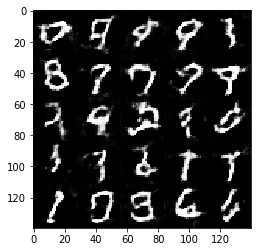

Epoch 1/2... Discriminator Loss: 0.4665... Generator Loss: 1.6388
Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 0.6619... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 0.5767... Generator Loss: 1.4211
Epoch 1/2... Discriminator Loss: 0.5882... Generator Loss: 2.2572


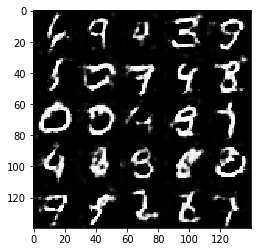

Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 0.5954
Epoch 1/2... Discriminator Loss: 0.4632... Generator Loss: 1.9332
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 1.6247
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 1.3276


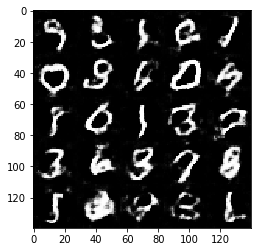

Epoch 1/2... Discriminator Loss: 0.5621... Generator Loss: 1.4795
Epoch 1/2... Discriminator Loss: 0.5548... Generator Loss: 1.8503
Epoch 1/2... Discriminator Loss: 0.5583... Generator Loss: 2.0466
Epoch 1/2... Discriminator Loss: 0.4912... Generator Loss: 1.5009
Epoch 1/2... Discriminator Loss: 0.5790... Generator Loss: 1.1798


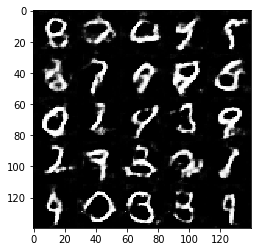

Epoch 1/2... Discriminator Loss: 0.5632... Generator Loss: 1.7581
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 1.5294
Epoch 1/2... Discriminator Loss: 0.6875... Generator Loss: 1.2927
Epoch 1/2... Discriminator Loss: 0.4666... Generator Loss: 1.7525
Epoch 1/2... Discriminator Loss: 0.6473... Generator Loss: 1.7267


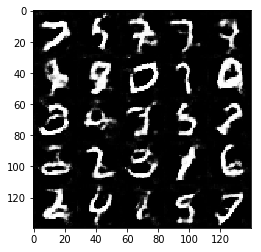

Epoch 1/2... Discriminator Loss: 0.6140... Generator Loss: 1.8052
Epoch 1/2... Discriminator Loss: 0.5018... Generator Loss: 1.3521
Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 2.3517


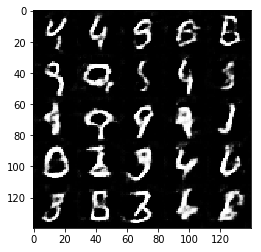

Epoch 1/2... Discriminator Loss: 0.5848... Generator Loss: 1.1679
Epoch 1/2... Discriminator Loss: 0.5582... Generator Loss: 1.4630
Epoch 1/2... Discriminator Loss: 0.5261... Generator Loss: 1.6690
Epoch 1/2... Discriminator Loss: 0.5716... Generator Loss: 1.2223
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 1.4910


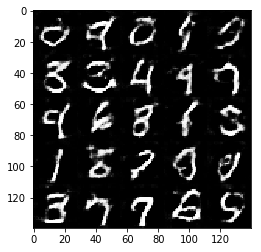

Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 0.6684... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 0.6047... Generator Loss: 1.2255
Epoch 1/2... Discriminator Loss: 0.4608... Generator Loss: 1.9504


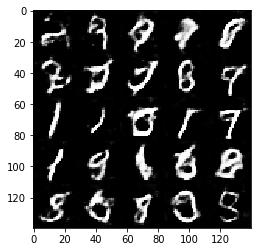

Epoch 1/2... Discriminator Loss: 0.5759... Generator Loss: 1.5927
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 0.6736... Generator Loss: 1.2045


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.5722... Generator Loss: 1.3621
Epoch 0/1... Discriminator Loss: 0.1507... Generator Loss: 9.8976
Epoch 0/1... Discriminator Loss: 0.1105... Generator Loss: 9.2681
Epoch 0/1... Discriminator Loss: 0.1025... Generator Loss: 12.9205


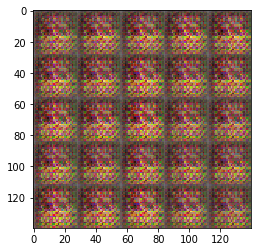

Epoch 0/1... Discriminator Loss: 0.6182... Generator Loss: 16.9493
Epoch 0/1... Discriminator Loss: 0.1154... Generator Loss: 7.3695
Epoch 0/1... Discriminator Loss: 0.4603... Generator Loss: 4.0654
Epoch 0/1... Discriminator Loss: 1.1900... Generator Loss: 0.5184
Epoch 0/1... Discriminator Loss: 1.2663... Generator Loss: 1.2469


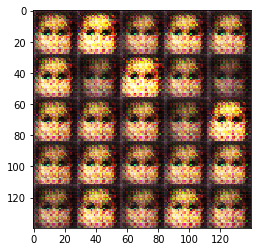

Epoch 0/1... Discriminator Loss: 0.4077... Generator Loss: 3.1622
Epoch 0/1... Discriminator Loss: 0.3319... Generator Loss: 1.5267
Epoch 0/1... Discriminator Loss: 0.8892... Generator Loss: 0.8117
Epoch 0/1... Discriminator Loss: 0.3521... Generator Loss: 2.1005
Epoch 0/1... Discriminator Loss: 0.2395... Generator Loss: 2.1992


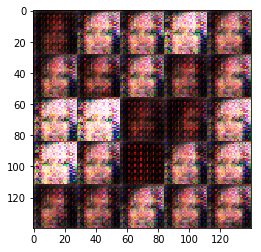

Epoch 0/1... Discriminator Loss: 0.8451... Generator Loss: 0.7272
Epoch 0/1... Discriminator Loss: 0.3830... Generator Loss: 1.4443
Epoch 0/1... Discriminator Loss: 0.7513... Generator Loss: 1.0491
Epoch 0/1... Discriminator Loss: 0.6060... Generator Loss: 0.9889
Epoch 0/1... Discriminator Loss: 0.1671... Generator Loss: 2.6046


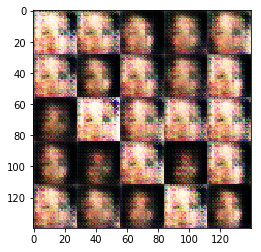

Epoch 0/1... Discriminator Loss: 1.1265... Generator Loss: 5.1789
Epoch 0/1... Discriminator Loss: 0.6710... Generator Loss: 3.0002
Epoch 0/1... Discriminator Loss: 3.6005... Generator Loss: 6.8843
Epoch 0/1... Discriminator Loss: 0.9614... Generator Loss: 0.9154
Epoch 0/1... Discriminator Loss: 1.2064... Generator Loss: 1.5702


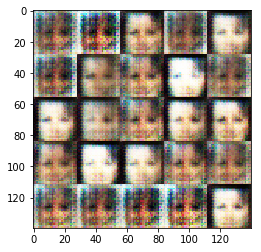

Epoch 0/1... Discriminator Loss: 1.6279... Generator Loss: 0.6066
Epoch 0/1... Discriminator Loss: 1.7254... Generator Loss: 0.4128
Epoch 0/1... Discriminator Loss: 1.4688... Generator Loss: 0.4305
Epoch 0/1... Discriminator Loss: 1.0526... Generator Loss: 1.5603
Epoch 0/1... Discriminator Loss: 1.2758... Generator Loss: 0.5146


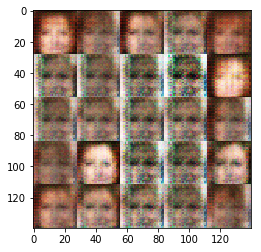

Epoch 0/1... Discriminator Loss: 0.8653... Generator Loss: 1.0371
Epoch 0/1... Discriminator Loss: 1.2192... Generator Loss: 3.1978
Epoch 0/1... Discriminator Loss: 0.6606... Generator Loss: 1.0686
Epoch 0/1... Discriminator Loss: 0.7248... Generator Loss: 1.0938
Epoch 0/1... Discriminator Loss: 0.7726... Generator Loss: 1.5580


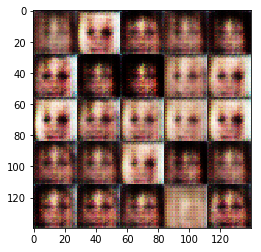

Epoch 0/1... Discriminator Loss: 1.0044... Generator Loss: 1.7295
Epoch 0/1... Discriminator Loss: 1.8156... Generator Loss: 0.6747
Epoch 0/1... Discriminator Loss: 1.1607... Generator Loss: 1.0523
Epoch 0/1... Discriminator Loss: 0.5809... Generator Loss: 1.8580
Epoch 0/1... Discriminator Loss: 0.5624... Generator Loss: 1.5250


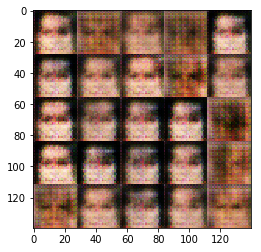

Epoch 0/1... Discriminator Loss: 1.2895... Generator Loss: 0.4387
Epoch 0/1... Discriminator Loss: 0.7891... Generator Loss: 0.9261
Epoch 0/1... Discriminator Loss: 0.8999... Generator Loss: 0.8149
Epoch 0/1... Discriminator Loss: 1.0771... Generator Loss: 1.0360
Epoch 0/1... Discriminator Loss: 0.6497... Generator Loss: 1.2712


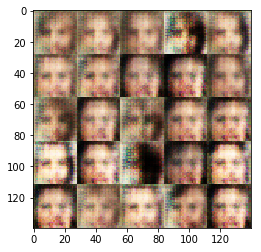

Epoch 0/1... Discriminator Loss: 0.6733... Generator Loss: 1.4291
Epoch 0/1... Discriminator Loss: 0.4792... Generator Loss: 1.5601
Epoch 0/1... Discriminator Loss: 0.6530... Generator Loss: 2.6440
Epoch 0/1... Discriminator Loss: 0.7257... Generator Loss: 1.3928
Epoch 0/1... Discriminator Loss: 0.8800... Generator Loss: 1.9897


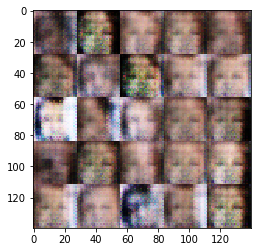

Epoch 0/1... Discriminator Loss: 1.1490... Generator Loss: 0.6017
Epoch 0/1... Discriminator Loss: 0.7208... Generator Loss: 2.4238
Epoch 0/1... Discriminator Loss: 0.9743... Generator Loss: 0.9240
Epoch 0/1... Discriminator Loss: 1.0807... Generator Loss: 0.7785
Epoch 0/1... Discriminator Loss: 1.4295... Generator Loss: 0.4613


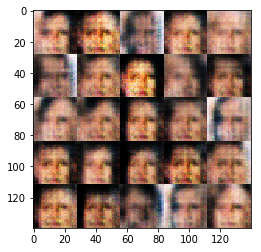

Epoch 0/1... Discriminator Loss: 0.6754... Generator Loss: 1.3947
Epoch 0/1... Discriminator Loss: 0.7966... Generator Loss: 1.1258
Epoch 0/1... Discriminator Loss: 0.6638... Generator Loss: 1.3090
Epoch 0/1... Discriminator Loss: 0.7029... Generator Loss: 1.0113
Epoch 0/1... Discriminator Loss: 1.1141... Generator Loss: 0.8344


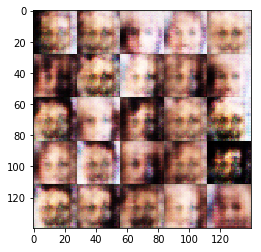

Epoch 0/1... Discriminator Loss: 0.8754... Generator Loss: 1.2795
Epoch 0/1... Discriminator Loss: 0.9857... Generator Loss: 1.0357
Epoch 0/1... Discriminator Loss: 1.1709... Generator Loss: 1.2137
Epoch 0/1... Discriminator Loss: 1.0309... Generator Loss: 2.0074
Epoch 0/1... Discriminator Loss: 1.7475... Generator Loss: 0.3297


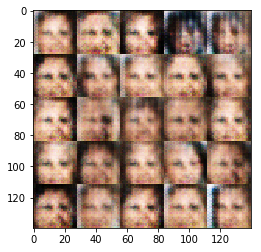

Epoch 0/1... Discriminator Loss: 0.6264... Generator Loss: 1.9081
Epoch 0/1... Discriminator Loss: 0.9829... Generator Loss: 1.4820
Epoch 0/1... Discriminator Loss: 0.9332... Generator Loss: 1.0462
Epoch 0/1... Discriminator Loss: 1.0590... Generator Loss: 1.0692
Epoch 0/1... Discriminator Loss: 1.0747... Generator Loss: 0.8434


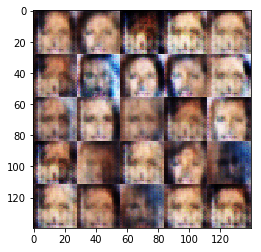

Epoch 0/1... Discriminator Loss: 0.8486... Generator Loss: 1.1638
Epoch 0/1... Discriminator Loss: 0.3694... Generator Loss: 3.3149
Epoch 0/1... Discriminator Loss: 0.9655... Generator Loss: 0.9782
Epoch 0/1... Discriminator Loss: 0.8232... Generator Loss: 1.2823
Epoch 0/1... Discriminator Loss: 1.3170... Generator Loss: 3.1889


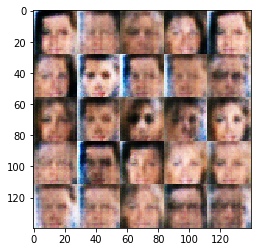

Epoch 0/1... Discriminator Loss: 0.7672... Generator Loss: 1.7756
Epoch 0/1... Discriminator Loss: 0.8488... Generator Loss: 1.4262
Epoch 0/1... Discriminator Loss: 0.6817... Generator Loss: 1.2864
Epoch 0/1... Discriminator Loss: 0.7863... Generator Loss: 1.2160
Epoch 0/1... Discriminator Loss: 0.7206... Generator Loss: 1.6119


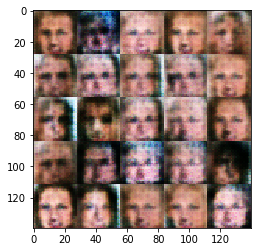

Epoch 0/1... Discriminator Loss: 0.8573... Generator Loss: 1.5877
Epoch 0/1... Discriminator Loss: 0.8524... Generator Loss: 1.5217
Epoch 0/1... Discriminator Loss: 0.8161... Generator Loss: 1.0620
Epoch 0/1... Discriminator Loss: 0.9773... Generator Loss: 0.9661
Epoch 0/1... Discriminator Loss: 0.8771... Generator Loss: 0.9693


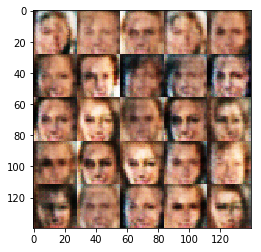

Epoch 0/1... Discriminator Loss: 0.7288... Generator Loss: 1.5021
Epoch 0/1... Discriminator Loss: 1.0497... Generator Loss: 1.0271
Epoch 0/1... Discriminator Loss: 0.8967... Generator Loss: 1.6498
Epoch 0/1... Discriminator Loss: 0.6104... Generator Loss: 1.3484
Epoch 0/1... Discriminator Loss: 0.9554... Generator Loss: 1.4329


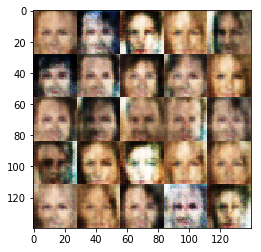

Epoch 0/1... Discriminator Loss: 0.7605... Generator Loss: 1.5578
Epoch 0/1... Discriminator Loss: 0.9939... Generator Loss: 2.2326
Epoch 0/1... Discriminator Loss: 0.8213... Generator Loss: 1.6947
Epoch 0/1... Discriminator Loss: 0.7294... Generator Loss: 1.3578
Epoch 0/1... Discriminator Loss: 0.7751... Generator Loss: 2.0775


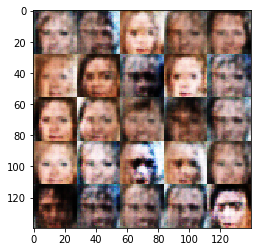

Epoch 0/1... Discriminator Loss: 1.2128... Generator Loss: 0.5414
Epoch 0/1... Discriminator Loss: 1.1043... Generator Loss: 1.0946
Epoch 0/1... Discriminator Loss: 0.9266... Generator Loss: 2.0814
Epoch 0/1... Discriminator Loss: 0.6153... Generator Loss: 1.5027
Epoch 0/1... Discriminator Loss: 1.1001... Generator Loss: 0.8105


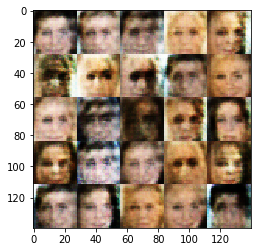

Epoch 0/1... Discriminator Loss: 0.6841... Generator Loss: 1.2303
Epoch 0/1... Discriminator Loss: 0.8167... Generator Loss: 0.9902
Epoch 0/1... Discriminator Loss: 0.9541... Generator Loss: 1.0286
Epoch 0/1... Discriminator Loss: 0.8514... Generator Loss: 1.1391
Epoch 0/1... Discriminator Loss: 1.1322... Generator Loss: 0.7323


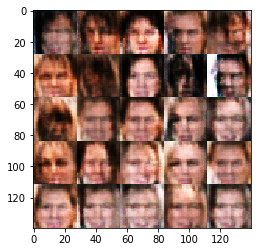

Epoch 0/1... Discriminator Loss: 1.2812... Generator Loss: 0.6383
Epoch 0/1... Discriminator Loss: 0.8808... Generator Loss: 1.0531
Epoch 0/1... Discriminator Loss: 0.9461... Generator Loss: 1.0381
Epoch 0/1... Discriminator Loss: 1.7175... Generator Loss: 2.7526
Epoch 0/1... Discriminator Loss: 1.2395... Generator Loss: 0.4826


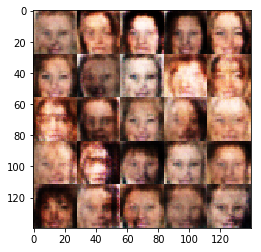

Epoch 0/1... Discriminator Loss: 0.9262... Generator Loss: 1.0128
Epoch 0/1... Discriminator Loss: 1.2166... Generator Loss: 0.5158
Epoch 0/1... Discriminator Loss: 0.7887... Generator Loss: 1.0845
Epoch 0/1... Discriminator Loss: 0.7933... Generator Loss: 1.8799
Epoch 0/1... Discriminator Loss: 0.9421... Generator Loss: 0.9563


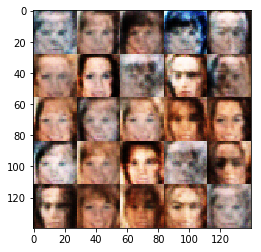

Epoch 0/1... Discriminator Loss: 0.6959... Generator Loss: 1.3400
Epoch 0/1... Discriminator Loss: 1.3158... Generator Loss: 0.5192
Epoch 0/1... Discriminator Loss: 0.6638... Generator Loss: 1.4294
Epoch 0/1... Discriminator Loss: 1.0537... Generator Loss: 0.6724
Epoch 0/1... Discriminator Loss: 1.0916... Generator Loss: 0.7116


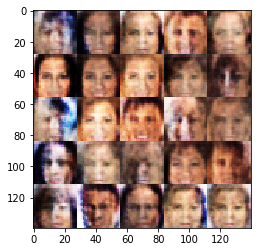

Epoch 0/1... Discriminator Loss: 0.9641... Generator Loss: 0.7760
Epoch 0/1... Discriminator Loss: 1.4654... Generator Loss: 0.4309
Epoch 0/1... Discriminator Loss: 0.6987... Generator Loss: 1.5726
Epoch 0/1... Discriminator Loss: 0.9369... Generator Loss: 1.0809
Epoch 0/1... Discriminator Loss: 0.8445... Generator Loss: 1.4212


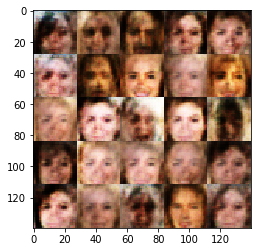

Epoch 0/1... Discriminator Loss: 1.0149... Generator Loss: 0.7085
Epoch 0/1... Discriminator Loss: 1.1428... Generator Loss: 0.6033
Epoch 0/1... Discriminator Loss: 1.0160... Generator Loss: 0.6837
Epoch 0/1... Discriminator Loss: 0.6526... Generator Loss: 1.3711
Epoch 0/1... Discriminator Loss: 0.8367... Generator Loss: 1.1274


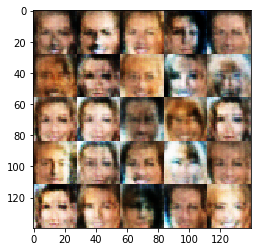

Epoch 0/1... Discriminator Loss: 0.8727... Generator Loss: 1.1516
Epoch 0/1... Discriminator Loss: 0.9067... Generator Loss: 1.2602
Epoch 0/1... Discriminator Loss: 1.0249... Generator Loss: 0.8410
Epoch 0/1... Discriminator Loss: 1.1693... Generator Loss: 1.0040
Epoch 0/1... Discriminator Loss: 0.7539... Generator Loss: 1.0407


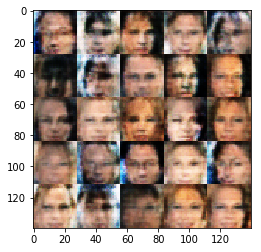

Epoch 0/1... Discriminator Loss: 0.9160... Generator Loss: 1.0192
Epoch 0/1... Discriminator Loss: 1.0556... Generator Loss: 1.9900
Epoch 0/1... Discriminator Loss: 0.6128... Generator Loss: 1.5184
Epoch 0/1... Discriminator Loss: 0.6548... Generator Loss: 1.4946
Epoch 0/1... Discriminator Loss: 0.9858... Generator Loss: 0.9885


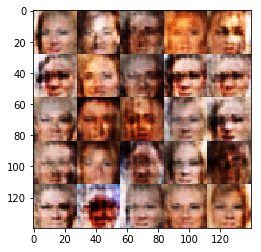

Epoch 0/1... Discriminator Loss: 0.6961... Generator Loss: 1.1970
Epoch 0/1... Discriminator Loss: 0.8193... Generator Loss: 1.5554
Epoch 0/1... Discriminator Loss: 0.7255... Generator Loss: 1.4724
Epoch 0/1... Discriminator Loss: 0.9597... Generator Loss: 2.1410
Epoch 0/1... Discriminator Loss: 0.8519... Generator Loss: 2.2618


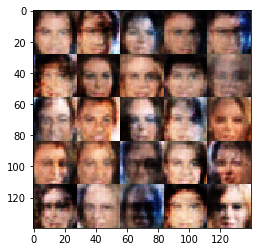

Epoch 0/1... Discriminator Loss: 0.8008... Generator Loss: 1.1918
Epoch 0/1... Discriminator Loss: 0.7611... Generator Loss: 1.2123
Epoch 0/1... Discriminator Loss: 0.9119... Generator Loss: 2.7652
Epoch 0/1... Discriminator Loss: 1.0628... Generator Loss: 0.7418
Epoch 0/1... Discriminator Loss: 0.9076... Generator Loss: 0.8910


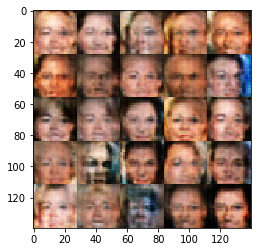

Epoch 0/1... Discriminator Loss: 1.0610... Generator Loss: 0.7646
Epoch 0/1... Discriminator Loss: 0.7451... Generator Loss: 1.8691
Epoch 0/1... Discriminator Loss: 0.8002... Generator Loss: 1.1855
Epoch 0/1... Discriminator Loss: 1.1155... Generator Loss: 0.6472
Epoch 0/1... Discriminator Loss: 1.1465... Generator Loss: 0.5919


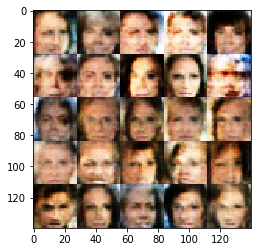

Epoch 0/1... Discriminator Loss: 1.1853... Generator Loss: 0.5796
Epoch 0/1... Discriminator Loss: 0.8319... Generator Loss: 1.0569
Epoch 0/1... Discriminator Loss: 1.0278... Generator Loss: 1.9244
Epoch 0/1... Discriminator Loss: 1.2017... Generator Loss: 0.5269
Epoch 0/1... Discriminator Loss: 1.0029... Generator Loss: 1.2252


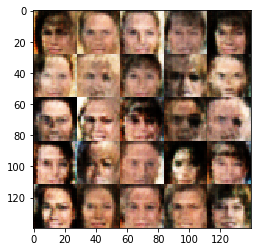

Epoch 0/1... Discriminator Loss: 1.2021... Generator Loss: 2.2068
Epoch 0/1... Discriminator Loss: 1.1077... Generator Loss: 0.8203
Epoch 0/1... Discriminator Loss: 0.9058... Generator Loss: 1.3371
Epoch 0/1... Discriminator Loss: 1.1675... Generator Loss: 0.5986
Epoch 0/1... Discriminator Loss: 0.8926... Generator Loss: 1.4417


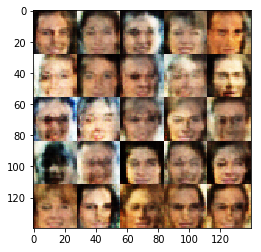

Epoch 0/1... Discriminator Loss: 1.1439... Generator Loss: 0.5649
Epoch 0/1... Discriminator Loss: 1.0373... Generator Loss: 0.6979
Epoch 0/1... Discriminator Loss: 0.6946... Generator Loss: 1.5261
Epoch 0/1... Discriminator Loss: 1.0114... Generator Loss: 0.7566
Epoch 0/1... Discriminator Loss: 0.8158... Generator Loss: 0.9846


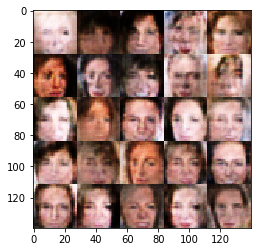

Epoch 0/1... Discriminator Loss: 0.7705... Generator Loss: 1.0200
Epoch 0/1... Discriminator Loss: 1.1855... Generator Loss: 0.5258
Epoch 0/1... Discriminator Loss: 0.7968... Generator Loss: 1.6535
Epoch 0/1... Discriminator Loss: 0.6202... Generator Loss: 1.5111
Epoch 0/1... Discriminator Loss: 0.9932... Generator Loss: 1.7491


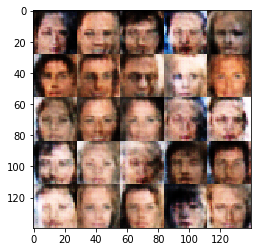

Epoch 0/1... Discriminator Loss: 1.1409... Generator Loss: 0.6640
Epoch 0/1... Discriminator Loss: 0.9425... Generator Loss: 0.8619
Epoch 0/1... Discriminator Loss: 0.8996... Generator Loss: 1.2967
Epoch 0/1... Discriminator Loss: 0.7966... Generator Loss: 1.0926
Epoch 0/1... Discriminator Loss: 0.9304... Generator Loss: 1.0806


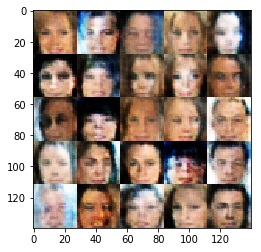

Epoch 0/1... Discriminator Loss: 1.2328... Generator Loss: 0.5746
Epoch 0/1... Discriminator Loss: 1.0513... Generator Loss: 1.9421
Epoch 0/1... Discriminator Loss: 0.9433... Generator Loss: 0.9620
Epoch 0/1... Discriminator Loss: 1.1135... Generator Loss: 2.1109
Epoch 0/1... Discriminator Loss: 0.9419... Generator Loss: 0.8777


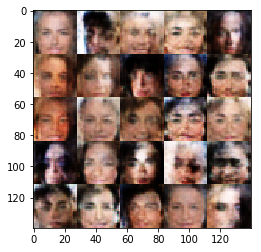

Epoch 0/1... Discriminator Loss: 1.4393... Generator Loss: 0.3751
Epoch 0/1... Discriminator Loss: 1.2371... Generator Loss: 1.2061
Epoch 0/1... Discriminator Loss: 0.6351... Generator Loss: 1.3778
Epoch 0/1... Discriminator Loss: 0.8102... Generator Loss: 1.4973
Epoch 0/1... Discriminator Loss: 0.8004... Generator Loss: 1.2991


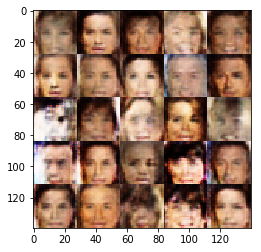

Epoch 0/1... Discriminator Loss: 1.4074... Generator Loss: 3.0531
Epoch 0/1... Discriminator Loss: 1.1716... Generator Loss: 1.2674
Epoch 0/1... Discriminator Loss: 0.8430... Generator Loss: 1.6840
Epoch 0/1... Discriminator Loss: 0.9417... Generator Loss: 1.0158
Epoch 0/1... Discriminator Loss: 1.0565... Generator Loss: 0.7251


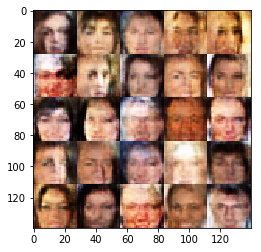

Epoch 0/1... Discriminator Loss: 0.8232... Generator Loss: 1.2107
Epoch 0/1... Discriminator Loss: 0.8369... Generator Loss: 1.1822
Epoch 0/1... Discriminator Loss: 1.5996... Generator Loss: 0.3905
Epoch 0/1... Discriminator Loss: 0.7549... Generator Loss: 1.6577
Epoch 0/1... Discriminator Loss: 1.1742... Generator Loss: 0.5898


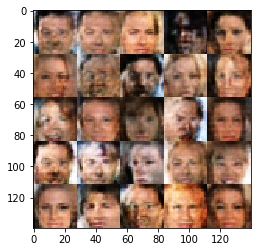

Epoch 0/1... Discriminator Loss: 0.9105... Generator Loss: 0.9249
Epoch 0/1... Discriminator Loss: 1.3072... Generator Loss: 0.5375
Epoch 0/1... Discriminator Loss: 0.8613... Generator Loss: 0.8921
Epoch 0/1... Discriminator Loss: 0.9317... Generator Loss: 0.7797
Epoch 0/1... Discriminator Loss: 0.8451... Generator Loss: 2.2393


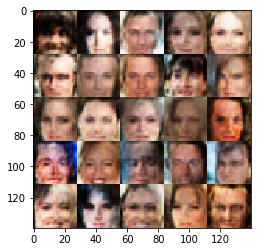

Epoch 0/1... Discriminator Loss: 0.8492... Generator Loss: 1.0395
Epoch 0/1... Discriminator Loss: 0.8494... Generator Loss: 1.7136
Epoch 0/1... Discriminator Loss: 0.8435... Generator Loss: 1.0771
Epoch 0/1... Discriminator Loss: 1.0411... Generator Loss: 2.3686
Epoch 0/1... Discriminator Loss: 0.9041... Generator Loss: 1.1412


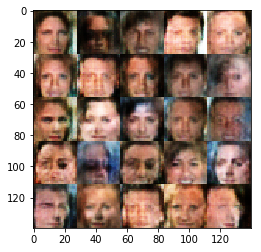

Epoch 0/1... Discriminator Loss: 1.0455... Generator Loss: 1.4136
Epoch 0/1... Discriminator Loss: 0.7485... Generator Loss: 1.4319
Epoch 0/1... Discriminator Loss: 1.3372... Generator Loss: 0.4508
Epoch 0/1... Discriminator Loss: 1.0509... Generator Loss: 2.1300
Epoch 0/1... Discriminator Loss: 0.6915... Generator Loss: 1.2804


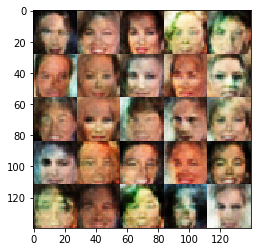

Epoch 0/1... Discriminator Loss: 1.5692... Generator Loss: 0.3231
Epoch 0/1... Discriminator Loss: 0.8877... Generator Loss: 1.0019
Epoch 0/1... Discriminator Loss: 0.6599... Generator Loss: 1.4060
Epoch 0/1... Discriminator Loss: 1.3358... Generator Loss: 0.6958
Epoch 0/1... Discriminator Loss: 1.2299... Generator Loss: 0.6091


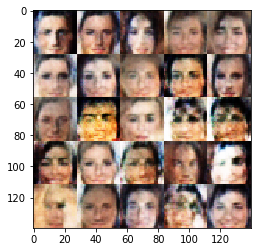

Epoch 0/1... Discriminator Loss: 0.6261... Generator Loss: 1.8262
Epoch 0/1... Discriminator Loss: 1.1440... Generator Loss: 0.6402
Epoch 0/1... Discriminator Loss: 1.1386... Generator Loss: 0.7254
Epoch 0/1... Discriminator Loss: 0.9530... Generator Loss: 0.9651
Epoch 0/1... Discriminator Loss: 1.0352... Generator Loss: 1.7613


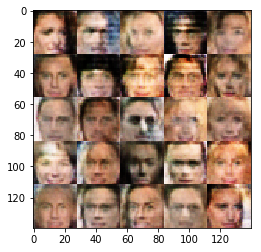

Epoch 0/1... Discriminator Loss: 1.1601... Generator Loss: 1.8022
Epoch 0/1... Discriminator Loss: 1.1224... Generator Loss: 0.6219
Epoch 0/1... Discriminator Loss: 1.0189... Generator Loss: 0.6781
Epoch 0/1... Discriminator Loss: 1.0009... Generator Loss: 0.7553
Epoch 0/1... Discriminator Loss: 0.8453... Generator Loss: 0.9902


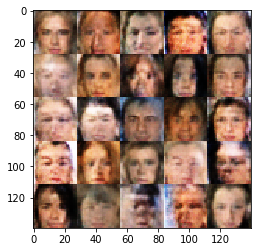

Epoch 0/1... Discriminator Loss: 0.9220... Generator Loss: 0.9679
Epoch 0/1... Discriminator Loss: 0.9180... Generator Loss: 0.8933
Epoch 0/1... Discriminator Loss: 1.1650... Generator Loss: 0.4906
Epoch 0/1... Discriminator Loss: 0.7537... Generator Loss: 1.3426
Epoch 0/1... Discriminator Loss: 1.0183... Generator Loss: 1.7401


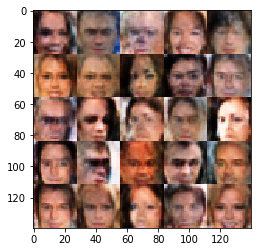

Epoch 0/1... Discriminator Loss: 0.7691... Generator Loss: 1.0874
Epoch 0/1... Discriminator Loss: 0.8189... Generator Loss: 1.7206
Epoch 0/1... Discriminator Loss: 1.2492... Generator Loss: 1.0108
Epoch 0/1... Discriminator Loss: 1.1464... Generator Loss: 0.6352
Epoch 0/1... Discriminator Loss: 0.9377... Generator Loss: 1.2582


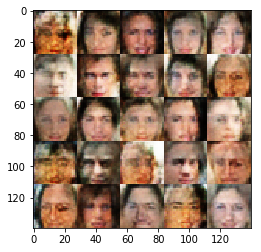

Epoch 0/1... Discriminator Loss: 0.8281... Generator Loss: 0.8723
Epoch 0/1... Discriminator Loss: 0.8271... Generator Loss: 0.9894
Epoch 0/1... Discriminator Loss: 0.5498... Generator Loss: 2.1573
Epoch 0/1... Discriminator Loss: 0.8964... Generator Loss: 0.7554
Epoch 0/1... Discriminator Loss: 0.7611... Generator Loss: 1.8787


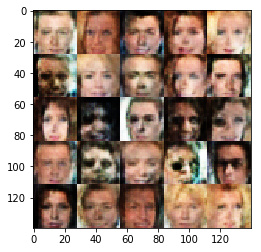

Epoch 0/1... Discriminator Loss: 0.6999... Generator Loss: 1.3373
Epoch 0/1... Discriminator Loss: 1.0188... Generator Loss: 0.8338
Epoch 0/1... Discriminator Loss: 1.1279... Generator Loss: 1.5540
Epoch 0/1... Discriminator Loss: 0.9760... Generator Loss: 0.9709
Epoch 0/1... Discriminator Loss: 1.2506... Generator Loss: 0.4987


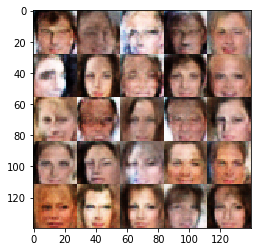

Epoch 0/1... Discriminator Loss: 0.8884... Generator Loss: 1.4630
Epoch 0/1... Discriminator Loss: 0.8734... Generator Loss: 1.3978
Epoch 0/1... Discriminator Loss: 0.9140... Generator Loss: 1.5501
Epoch 0/1... Discriminator Loss: 0.8146... Generator Loss: 1.3248
Epoch 0/1... Discriminator Loss: 0.9279... Generator Loss: 1.1858


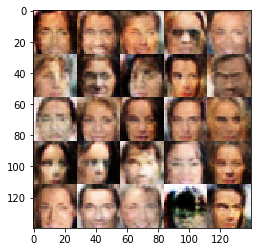

Epoch 0/1... Discriminator Loss: 0.8293... Generator Loss: 1.0488
Epoch 0/1... Discriminator Loss: 0.9219... Generator Loss: 0.8513
Epoch 0/1... Discriminator Loss: 0.7960... Generator Loss: 1.1513
Epoch 0/1... Discriminator Loss: 1.0463... Generator Loss: 1.6556
Epoch 0/1... Discriminator Loss: 0.8248... Generator Loss: 1.1266


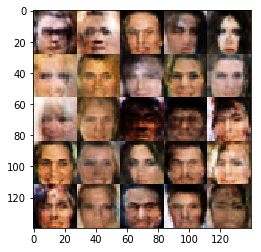

Epoch 0/1... Discriminator Loss: 0.6561... Generator Loss: 1.1889
Epoch 0/1... Discriminator Loss: 1.0527... Generator Loss: 0.7454
Epoch 0/1... Discriminator Loss: 0.8622... Generator Loss: 1.2375
Epoch 0/1... Discriminator Loss: 0.7692... Generator Loss: 1.0248
Epoch 0/1... Discriminator Loss: 0.9082... Generator Loss: 1.3722


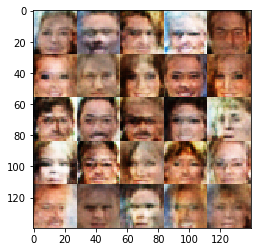

Epoch 0/1... Discriminator Loss: 0.9933... Generator Loss: 0.7667
Epoch 0/1... Discriminator Loss: 0.8413... Generator Loss: 1.4990
Epoch 0/1... Discriminator Loss: 0.8723... Generator Loss: 1.7376
Epoch 0/1... Discriminator Loss: 0.7254... Generator Loss: 1.3057
Epoch 0/1... Discriminator Loss: 0.7899... Generator Loss: 1.4180


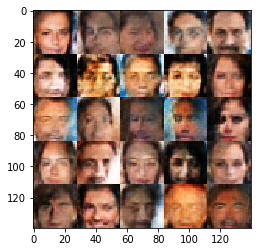

Epoch 0/1... Discriminator Loss: 1.2253... Generator Loss: 0.5710
Epoch 0/1... Discriminator Loss: 0.9513... Generator Loss: 0.7501
Epoch 0/1... Discriminator Loss: 1.0482... Generator Loss: 0.6251
Epoch 0/1... Discriminator Loss: 1.0002... Generator Loss: 1.7295
Epoch 0/1... Discriminator Loss: 0.9296... Generator Loss: 1.7484


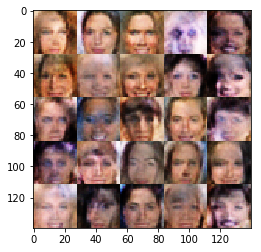

Epoch 0/1... Discriminator Loss: 0.8684... Generator Loss: 0.9957
Epoch 0/1... Discriminator Loss: 1.5573... Generator Loss: 0.3440
Epoch 0/1... Discriminator Loss: 1.1524... Generator Loss: 1.9587
Epoch 0/1... Discriminator Loss: 1.0686... Generator Loss: 0.7845
Epoch 0/1... Discriminator Loss: 0.5833... Generator Loss: 1.7584


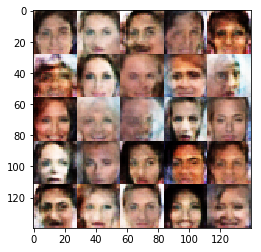

Epoch 0/1... Discriminator Loss: 1.0373... Generator Loss: 1.9577
Epoch 0/1... Discriminator Loss: 0.7527... Generator Loss: 1.9103
Epoch 0/1... Discriminator Loss: 1.3891... Generator Loss: 0.4467
Epoch 0/1... Discriminator Loss: 0.8967... Generator Loss: 0.7545
Epoch 0/1... Discriminator Loss: 0.4746... Generator Loss: 2.1087


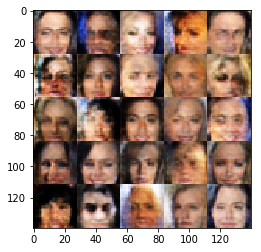

Epoch 0/1... Discriminator Loss: 0.8972... Generator Loss: 0.8434
Epoch 0/1... Discriminator Loss: 0.8440... Generator Loss: 1.4927
Epoch 0/1... Discriminator Loss: 1.0140... Generator Loss: 2.3161
Epoch 0/1... Discriminator Loss: 0.4676... Generator Loss: 2.0420
Epoch 0/1... Discriminator Loss: 0.8339... Generator Loss: 0.9891


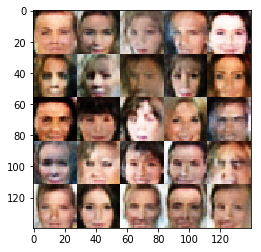

Epoch 0/1... Discriminator Loss: 0.9157... Generator Loss: 0.8239
Epoch 0/1... Discriminator Loss: 0.9674... Generator Loss: 0.7710
Epoch 0/1... Discriminator Loss: 1.0490... Generator Loss: 0.6734
Epoch 0/1... Discriminator Loss: 0.9453... Generator Loss: 0.9556
Epoch 0/1... Discriminator Loss: 0.9749... Generator Loss: 1.4285


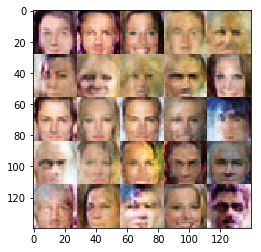

Epoch 0/1... Discriminator Loss: 0.9408... Generator Loss: 2.5222
Epoch 0/1... Discriminator Loss: 0.6754... Generator Loss: 1.4729
Epoch 0/1... Discriminator Loss: 0.9881... Generator Loss: 0.7834
Epoch 0/1... Discriminator Loss: 1.5357... Generator Loss: 0.3485
Epoch 0/1... Discriminator Loss: 1.1123... Generator Loss: 1.5866


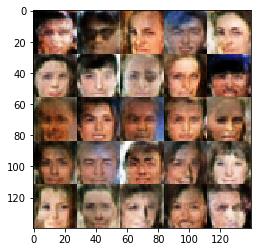

Epoch 0/1... Discriminator Loss: 1.0277... Generator Loss: 0.7595
Epoch 0/1... Discriminator Loss: 0.7372... Generator Loss: 1.1434
Epoch 0/1... Discriminator Loss: 0.6770... Generator Loss: 1.4790
Epoch 0/1... Discriminator Loss: 0.8022... Generator Loss: 1.0517
Epoch 0/1... Discriminator Loss: 0.6053... Generator Loss: 2.0310


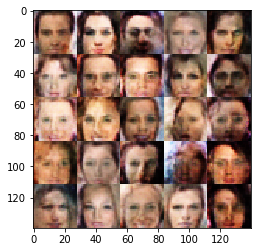

Epoch 0/1... Discriminator Loss: 0.7812... Generator Loss: 1.3619
Epoch 0/1... Discriminator Loss: 0.9105... Generator Loss: 1.7642
Epoch 0/1... Discriminator Loss: 0.9110... Generator Loss: 0.7917
Epoch 0/1... Discriminator Loss: 0.7742... Generator Loss: 2.0219
Epoch 0/1... Discriminator Loss: 1.1489... Generator Loss: 0.5916


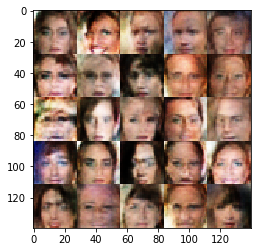

Epoch 0/1... Discriminator Loss: 0.9720... Generator Loss: 1.6515
Epoch 0/1... Discriminator Loss: 0.5239... Generator Loss: 1.5944
Epoch 0/1... Discriminator Loss: 0.6230... Generator Loss: 1.4471
Epoch 0/1... Discriminator Loss: 0.9810... Generator Loss: 1.1029
Epoch 0/1... Discriminator Loss: 1.1383... Generator Loss: 1.6263


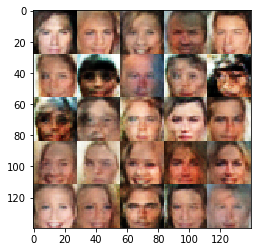

Epoch 0/1... Discriminator Loss: 0.9077... Generator Loss: 1.0117
Epoch 0/1... Discriminator Loss: 0.7962... Generator Loss: 1.8685


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.